# Data pre-processing & tokenization

CS685 Spring 2022 <br />
Apr. 2, 2022<br />
Hongyu Tu <br />

In [1]:
import torch
import pickle
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")
model = AutoModelForMaskedLM.from_pretrained("bert-base-chinese")

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
tmp_lst = []

for i in ['danmu', 'comment']:
    with open('{}_token.pkl'.format(i), 'rb') as f:
        tmp = pickle.load(f)
        tmp_lst.append(tmp)
    with open('{}_dist.pkl'.format(i), 'rb') as f:
        tmp = pickle.load(f)
        tmp_lst.append(tmp)
        
danmu_token, danmu_dist, comment_token, comment_dist = tmp_lst

In [5]:
def tok_ten(token_lst, dist_lst):
    lst = [tokenizer(i)['input_ids'][1:-1] for i in token_lst]
    max_length = np.max(np.array([len(i) for i in lst]))
    tmp_lst = []
    for i in range(len(lst)):
        tmp = np.concatenate([lst[i], -np.ones(1 + max_length - len(lst[i]))]) 
        tmp_lst.append(tmp[:10])
    output = torch.from_numpy(np.array(tmp_lst).astype(np.float32)).to(device=device), \
             torch.from_numpy(np.array(dist_lst).astype(np.float32)).to(device=device)
    return output

In [6]:
danmu_x, danmu_y = tok_ten(danmu_token, danmu_dist)
comment_x, comment_y = tok_ten(comment_token, comment_dist)

In [7]:
from torch.autograd import Variable

In [8]:
X_train, X_test, y_train, y_test = train_test_split(danmu_x, danmu_y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [9]:
X_train.shape[0], X_val.shape[0], X_test.shape[0]
inputDim, outputDim = X_train.shape[1], y_train.shape[1]

In [10]:
size1, size2 = inputDim, outputDim
L1, L2, L3 = 50, 100, 50

model = nn.Sequential(
    
    nn.Linear(size1, L1),
    nn.LeakyReLU(0.1),
    nn.Linear(L1, L2),
    nn.LeakyReLU(0.1),
    nn.Dropout(0.2),
    nn.Linear(L2, L3),
    nn.LeakyReLU(0.1),
    nn.Linear(L3, size2),
    nn.Softmax(dim=1)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [11]:
length = len(X_train)
learningRate = 1e-8
epochs = 2000

In [12]:
loss_his = []
for epoch in tqdm(range(epochs)):
    rand_idx = np.random.permutation(length)[:int(length/10)]
    x = X_train[rand_idx]
    y = y_train[rand_idx]
    
    model.train()
    outputs = model(x)
    loss = criterion(outputs, y)
    loss_his.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    outputs = model(X_val)
    loss = criterion(outputs, y_val)
    
    if epoch % int(epochs/5) == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

  1%|▌                                                                               | 14/2000 [00:00<01:30, 21.99it/s]

epoch 0, loss 4.836490631103516


 21%|████████████████▍                                                             | 422/2000 [00:03<00:12, 129.86it/s]

epoch 400, loss 4.811614990234375


 41%|████████████████████████████████▏                                             | 825/2000 [00:07<00:09, 122.30it/s]

epoch 800, loss 4.811792373657227


 61%|██████████████████████████████████████████████▊                              | 1215/2000 [00:10<00:06, 126.35it/s]

epoch 1200, loss 4.81171989440918


 81%|██████████████████████████████████████████████████████████████▌              | 1624/2000 [00:13<00:02, 130.29it/s]

epoch 1600, loss 4.811801433563232


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 121.93it/s]


In [13]:
def score(pred, answer):
    if 1 in answer: 
        correct = torch.argmax(answer).item()
        pred = torch.argmax(pred).item()
        return 1 if pred == correct else 0
    else:
        correct_idx = torch.where(answer != 0)[0].detach().cpu().numpy()
        return torch.sum(pred[correct_idx]).item()

In [14]:
x, y = X_val, y_val
outputs = model(x)
a = np.sum([score(outputs[i], y[i]) for i in range(len(x))])/len(x)

In [15]:
a

0.05070006884254856

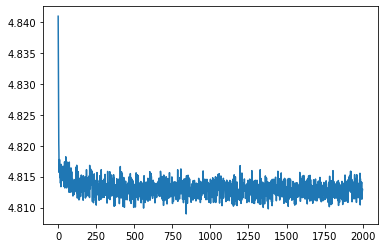

In [16]:
plt.plot(list(range(len(loss_his))), loss_his)
plt.show()